In [1]:
!pip install transformers --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.6/565.6 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00


In [2]:
import mlflow
from google.colab import drive
drive.mount('/content/drive')
train_json_file = '/content/drive/MyDrive/data-dsde/train.json'
test_json_file = '/content/drive/MyDrive/data-dsde/test.json'
mlflow.set_tracking_uri('file:///content/drive/MyDrive/data-dsde/mlruns')

Mounted at /content/drive


## Data Exporation

Classes
CHE       177
CPE       142
MATSCI    119
EE        118
MATH      112
ME         90
PE         86
IE         74
METAL      72
MATENG     64
ENV        59
CE         52
BME        36
EDU        32
NANO       32
OPTIC      31
SAFETY     22
AGRI       20
Name: count, dtype: int64


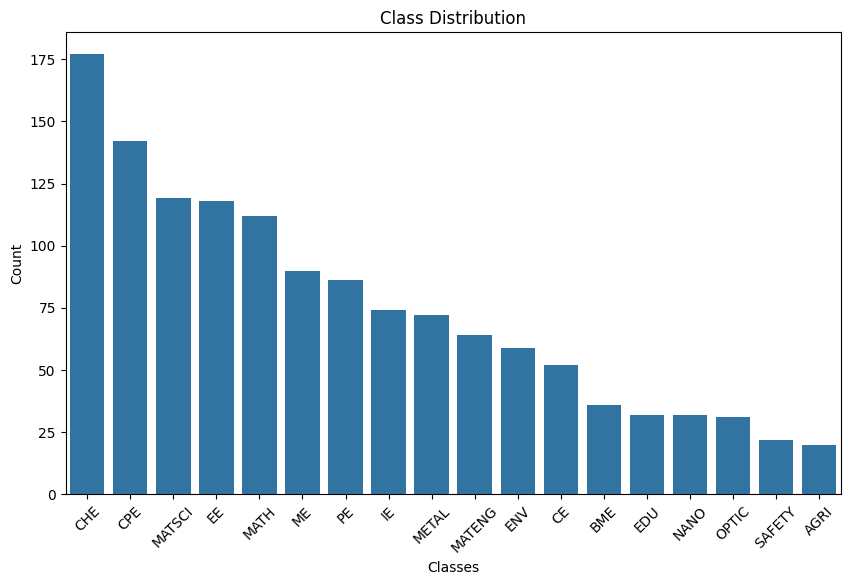

<class 'pandas.core.frame.DataFrame'>
Index: 454 entries, 1 to 454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     454 non-null    object
 1   Abstract  454 non-null    object
 2   Classes   454 non-null    object
dtypes: object(3)
memory usage: 30.4+ KB
None


,Title,Abstract,Classes
count,454,454,454
unique,453,454,284
top,Structure and mechanical properties of ADC 12 ...,© 2019 Elsevier B.V.Activated carbon derived f...,[CPE]
freq,2,1,29


In [8]:
# Data Exporation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_json(train_json_file).transpose()

# Assuming your DataFrame is called df and the labels are in a column called 'Classes'
class_counts = df['Classes'].explode().value_counts()
print(class_counts)
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
print(df.info())
df.describe()

In [18]:
# Drop duplicates
df_unique = df.drop_duplicates(subset=['Title'])
df_unique.shape

(453, 3)

## Data Preparation

In [5]:
import pandas as pd
import numpy as np
import json
import torch
import re
from transformers import DistilBertTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
import tqdm as notebook_tqdm
import spacy

import mlflow
import mlflow.pytorch
from transformers import DistilBertModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load dataset
train_df = pd.read_json(train_json_file).transpose()


nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()
    # Remove © symbols
    text = text.replace('©', '')
    # Remove numbers
    text = re.sub(r'\d+', ' ', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def lemmatize_text(text):
    # Word lemmatize
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def pre_process_text(text):
    text = preprocess_text(text)
    text = lemmatize_text(text)
    return text

train_df['Text'] = train_df['Title'].apply(pre_process_text) + " " + train_df['Abstract'].apply(pre_process_text)
texts = train_df['Text'].tolist()
labels = train_df['Classes'].tolist()

# Define class labels (list of unique subject areas)
label_classes = ['CE', 'ENV', 'BME', 'PE', 'METAL', 'ME', 'EE', 'CPE', 'OPTIC',
                 'NANO', 'CHE', 'MATENG', 'AGRI', 'EDU', 'IE', 'SAFETY', 'MATH', 'MATSCI']

# Binarize the labels for multi-label classification
mlb = MultiLabelBinarizer(classes=label_classes)
binarized_labels = mlb.fit_transform(labels)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, binarized_labels, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Flatten the list of labels
flattened_labels = []
for sublist in labels:
    flattened_labels.extend(sublist)

# Convert to numpy array
flattened_labels = np.array(flattened_labels)

# Define the classes
# classes = np.array(['CHE', 'CPE', 'MATSCI', 'EE', 'MATH', 'ME', 'PE', 'IE',
#                    'METAL', 'MATENG', 'ENV', 'CE', 'BME', 'EDU', 'NANO',
#                    'OPTIC', 'SAFETY', 'AGRI'])
classes = np.array(label_classes)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=classes, y=flattened_labels)
class_weights = torch.FloatTensor(class_weights).to(device)


# Custom Dataset class for BERT input
class ScopusDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize the input text
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)  # Multi-label target
        }

# Hyperparameters
MAX_LEN = 512
BATCH_SIZE = 16

# Create the dataset and dataloader
train_dataset = ScopusDataset(train_texts, train_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = ScopusDataset(val_texts, val_labels, tokenizer, MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



class BERTMultiLabelClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTMultiLabelClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Pass inputs through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        output = self.dropout(pooled_output)
        return self.out(output)

# Training function
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(data_loader)

# Evaluation function
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions.append(torch.sigmoid(outputs).cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    return total_loss / len(data_loader), predictions, true_labels



/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# DistillBert fine tune
# Training loop with MLflow
N_EPOCHS = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Start MLflow run
with mlflow.start_run():
    model = BERTMultiLabelClassifier(n_classes=len(label_classes))
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    # Log hyperparameters
    mlflow.log_param("epochs", N_EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", 2e-5)
    mlflow.log_param("model", "DistilBERT-base-uncased")

    for epoch in range(N_EPOCHS):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_preds, val_true = eval_model(model, val_loader, criterion, device)

        # Convert predictions to binary format (threshold of 0.5)
        val_preds = (val_preds > 0.5).astype(int)

        # Compute evaluation metrics
        f1 = f1_score(val_true, val_preds, average='micro')

        # Log metrics for each epoch
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("f1_score", f1, step=epoch)

        print(f'Epoch {epoch + 1}/{N_EPOCHS}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'F1 Score: {f1:.4f}')

    # Log the model at the end of training
    mlflow.pytorch.log_model(model, "bert_multi_label_model")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/15
Train Loss: 0.5200
Validation Loss: 0.4443
F1 Score: 0.0000
Epoch 2/15
Train Loss: 0.4385
Validation Loss: 0.4237
F1 Score: 0.0000
Epoch 3/15
Train Loss: 0.4067
Validation Loss: 0.3981
F1 Score: 0.1433
Epoch 4/15
Train Loss: 0.3731
Validation Loss: 0.3670
F1 Score: 0.2822
Epoch 5/15
Train Loss: 0.3415
Validation Loss: 0.3509
F1 Score: 0.3573
Epoch 6/15
Train Loss: 0.3153
Validation Loss: 0.3450
F1 Score: 0.4241
Epoch 7/15
Train Loss: 0.2945
Validation Loss: 0.3352
F1 Score: 0.4841
Epoch 8/15
Train Loss: 0.2763
Validation Loss: 0.3289
F1 Score: 0.4492
Epoch 9/15
Train Loss: 0.2573
Validation Loss: 0.3225
F1 Score: 0.4651
Epoch 10/15
Train Loss: 0.2414
Validation Loss: 0.3177
F1 Score: 0.4988
Epoch 11/15
Train Loss: 0.2259
Validation Loss: 0.3098
F1 Score: 0.5215
Epoch 12/15
Train Loss: 0.2106
Validation Loss: 0.3082
F1 Score: 0.5298
Epoch 13/15
Train Loss: 0.1982
Validation Loss: 0.3062
F1 Score: 0.5506
Epoch 14/15
Train Loss: 0.1868
Validation Loss: 0.3058
F1 Score: 0.5266
E

2024/10/15 11:19:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/15 11:19:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [10]:
# DistillBERT Predict
import pandas as pd
import torch
import mlflow
import mlflow.pytorch
from transformers import DistilBertTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
import json


run_id = '2bc71f435226439cba2bbe3c8ed19bb1' # Best - distill bert, weighted class, micro, preprocess, 30 epoch (predictions-3-distillbert-micro-30ep.csv)
model_uri = f"runs:/{run_id}/bert_multi_label_model"
model = mlflow.pytorch.load_model(model_uri)
model.eval()

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load the test data
with open(test_json_file, 'r') as f:
    test_data = json.load(f)

# Preprocess and join the title and abstract
unseen_texts = []
ids = []
for key, value in test_data.items():
    # Apply the pre_process_text function directly to the strings
    title = pre_process_text(value['Title'])
    abstract = pre_process_text(value['Abstract'])

    # Concatenate the processed title and abstract
    unseen_texts.append(title + " " + abstract)
    ids.append(key)  # Store the id

# Function to preprocess unseen texts
def preprocess_texts(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            max_length=max_len,
            truncation=True,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    return torch.cat(input_ids), torch.cat(attention_masks)

# Preprocess the unseen texts
MAX_LEN = 512  # Ensure this matches the training
input_ids, attention_mask = preprocess_texts(unseen_texts, tokenizer, MAX_LEN)

# Move the input data to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Apply sigmoid and threshold to get binary predictions
predictions = torch.sigmoid(outputs).cpu().numpy()
binary_predictions = (predictions > 0.5).astype(int)

# Decode the predictions back to class labels
# mlb = MultiLabelBinarizer(classes=label_classes)
# mlb.fit([label_classes])  # Fit to the classes

# Create a DataFrame to hold the results
results_df = pd.DataFrame(binary_predictions, columns=label_classes)
results_df.insert(0, 'id', ids)  # Insert the 'id' column at the beginning

# Save the results to a CSV file
results_df.to_csv('/content/drive/MyDrive/data-dsde/predictions.csv', index=False)

print("Predictions saved to predictions.csv")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Predictions saved to predictions.csv


In [ ]:
# MLflow
from google.colab import drive
from pyngrok import ngrok
import mlflow
import os
import subprocess
from datetime import datetime

class MLflowManager:
    def __init__(self, drive_path='My Drive/mlflow',ngrok_auth_token=None):
        self.drive_path = drive_path
        self.mlflow_uri = f'file:///content/drive/{self.drive_path}'
        self.ngrok_auth_token=ngrok_auth_token
        self.client = mlflow.tracking.MlflowClient()

    def mount_drive(self):
        try:
            drive.mount('/content/drive')
            print("Google Drive mounted successfully.")
        except Exception as e:
            print(f"Error mounting Google Drive: {e}")

    def install_packages(self):
        try:
            subprocess.check_call(["pip", "install", "mlflow", "pyngrok"])
            print("Packages installed successfully.")
        except Exception as e:
            print(f"Error installing packages: {e}")

    def start_mlflow(self):
        try:
            subprocess.Popen(["mlflow", "ui", "--backend-store-uri", self.mlflow_uri, "--host", "0.0.0.0", "--port", "5000"])
            print(f"MLflow server started successfully. Tracking {self.mlflow_uri}")
        except Exception as e:
            print(f"Error starting MLflow server: {e}")

    def expose_with_ngrok(self):
        try:
            public_url = ngrok.connect(5000)
            print(f"MLflow UI is available at: {public_url}")
        except Exception as e:
            print(f"Error exposing MLflow UI with Ngrok: {e}")

    def set_ngrok_auth_token(self, auth_token):
        ngrok.set_auth_token(auth_token)

    def get_ngrok_auth_token_from_drive(self, path):
        with open(f'/content/drive/MyDrive/{path}', 'r') as file:
            return file.read().strip()

    def start_ui(self):
        if self.ngrok_auth_token is None:
            self.ngrok_auth_token = self.get_ngrok_auth_token_from_drive('ngrok_auth_token.txt')
        self.set_ngrok_auth_token(self.ngrok_auth_token)
        self.expose_with_ngrok()


    def setup_mlflow(self):
        self.mount_drive()
        self.install_packages()
        mlflow.set_tracking_uri(self.mlflow_uri)
        self.start_mlflow()
        # self.print_summary()

    def list_experiments(self):
        experiments = mlflow.search_experiments()
        experiment_data = []
        for experiment in experiments:
            runs = self.list_runs(experiment.experiment_id)
            experiment_data.append({
                "name": experiment.name,
                "id": experiment.experiment_id,
                "runs": runs
            })
        return experiment_data

    def list_runs(self, experiment_id):
        runs = mlflow.search_runs(experiment_ids=[experiment_id])
        run_data = []
        for _, run in runs.iterrows():
            run_data.append({
                "run_id": run.run_id,
                "model_uri": run.artifact_uri
            })
        return run_data

    def list_registered_models(self):
        registered_models = self.client.search_registered_models()
        model_data = []
        for model in registered_models:
            # Retrieve the latest version of the registered model
            model_versions = self.client.get_registered_model(model.name).latest_versions
            latest_version = model_versions[0].version if model_versions else "None"
            creation_time = model_versions[0].creation_timestamp
            creation_time_iso = datetime.fromtimestamp(creation_time / 1000).isoformat()
            model_data.append({
                "name": model.name,
                "latest_version": latest_version,
                "creation_time": creation_time_iso
            })
        return model_data

    def print_summary(self):
        print("Experiments and Runs:")
        experiments = self.list_experiments()
        for experiment in experiments:
            print(f"Experiment Name: {experiment['name']}, ID: {experiment['id']}")
            for run in experiment['runs']:
                print(f"  Run ID: {run['run_id']}, Model URI: {run['model_uri']}")

        print("\nRegistered Models:")
        registered_models = self.list_registered_models()
        for model in registered_models:
            print(f"Model Name: {model['name']}, Latest Version: {model['latest_version']}, Creation Time: {model['creation_time']}")


def start_mlflow_dashboard():
    mlflow_manager = MLflowManager('MyDrive/data-dsde/mlruns')
    mlflow_manager.setup_mlflow()
    mlflow_manager.start_ui()

In [ ]:
# Lanuch mlflow dashboard
start_mlflow_dashboard()